# Digital Marketing Conversion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, 
                             precision_recall_curve, roc_curve, auc, 
                             ConfusionMatrixDisplay, silhouette_score, 
                             f1_score, davies_bouldin_score, calinski_harabasz_score)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
# Load the dataset
file_path = 'data/digital_marketing_campaign_dataset.csv'
df = pd.read_csv(file_path)

# Drop confidential columns and IDs
df.drop(['CustomerID', 'AdvertisingPlatform', 'AdvertisingTool'], axis=1, inplace=True)

# Display the first few rows of the dataframe
df.head()

Age  Gender  Income CampaignChannel CampaignType      AdSpend  \
0   56  Female  136912    Social Media    Awareness  6497.870068   
1   69    Male   41760           Email    Retention  3898.668606   
2   46  Female   88456             PPC    Awareness  1546.429596   
3   32  Female   44085             PPC   Conversion   539.525936   
4   60  Female   83964             PPC   Conversion  1678.043573   

   ClickThroughRate  ConversionRate  WebsiteVisits  PagesPerVisit  TimeOnSite  \
0          0.043919        0.088031              0       2.399017    7.396803   
1          0.155725        0.182725             42       2.917138    5.352549   
2          0.277490        0.076423              2       8.223619   13.794901   
3          0.137611        0.088004             47       4.540939   14.688363   
4          0.252851        0.109940              0       2.046847   13.993370   

   SocialShares  EmailOpens  EmailClicks  PreviousPurchases  LoyaltyPoints  \
0            19           6            9                  4            688   
1             5           2            7                  2           3459   
2             0          11            2                  8           2337   
3            89           2            2                  0           2463   
4             6           6            6                  8           4345   

   Conversion  
0           1  
1           1  
2           1  
3           1  
4           1

## Exploratory Data Analysis

In [3]:
# Get a summary of the dataset
df.info()

# Get descriptive statistics
df.describe()

# Check for missing values
df.isnull().sum().max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                8000 non-null   int64  
 1   Gender             8000 non-null   object 
 2   Income             8000 non-null   int64  
 3   CampaignChannel    8000 non-null   object 
 4   CampaignType       8000 non-null   object 
 5   AdSpend            8000 non-null   float64
 6   ClickThroughRate   8000 non-null   float64
 7   ConversionRate     8000 non-null   float64
 8   WebsiteVisits      8000 non-null   int64  
 9   PagesPerVisit      8000 non-null   float64
 10  TimeOnSite         8000 non-null   float64
 11  SocialShares       8000 non-null   int64  
 12  EmailOpens         8000 non-null   int64  
 13  EmailClicks        8000 non-null   int64  
 14  PreviousPurchases  8000 non-null   int64  
 15  LoyaltyPoints      8000 non-null   int64  
 16  Conversion         8000 

0

## Data Visualization

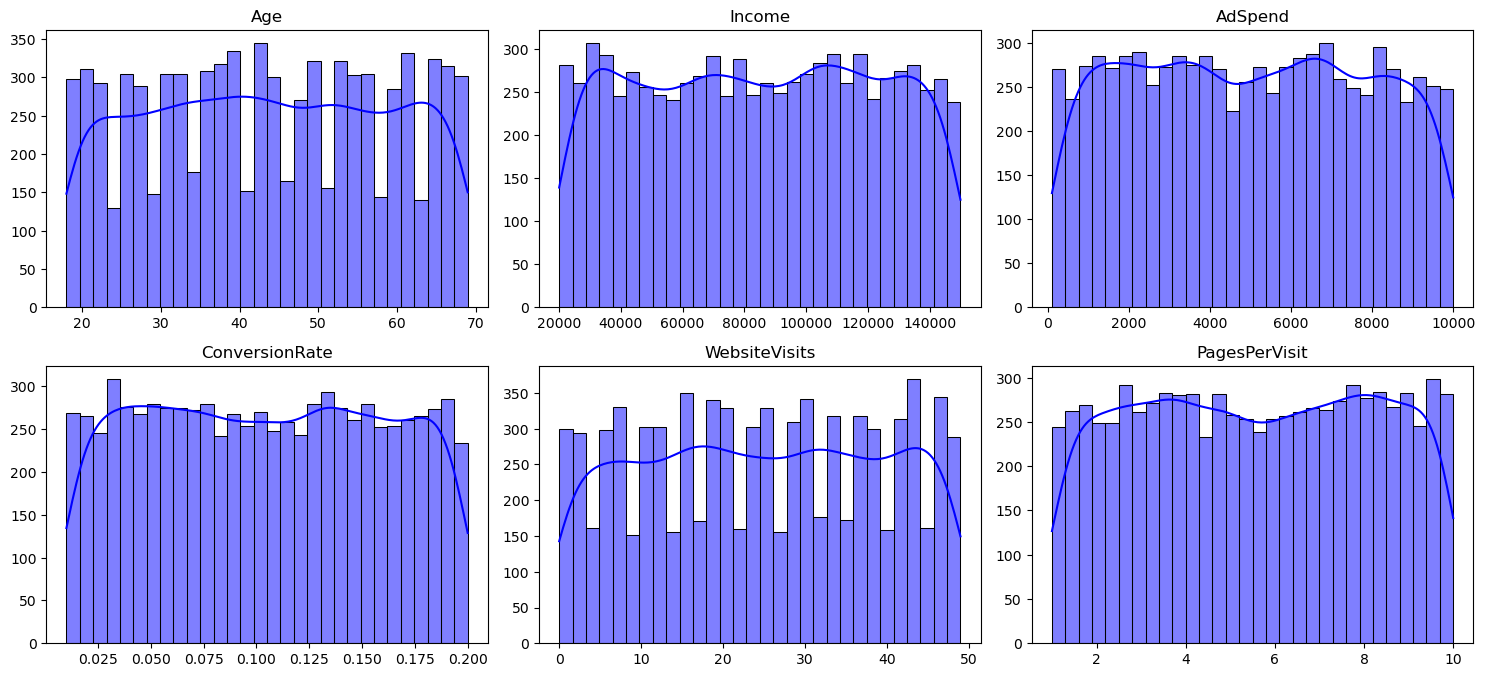

In [106]:
# Select numerical features to visualize
interesting_features = ['Age', 'Income', 'AdSpend', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(interesting_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[feature], bins=30, kde=True, color='blue')
    plt.title(f'{feature}')
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

The distributions for our selected features can be broken down as follows:
- **Age**: The age range of customers is uniformly distributed from 20 to 70 years, reflecting a wide demographic reach.
- **Income**: Income levels range from $25,000 to $150,000, indicating a diverse economic background among customers.
- **AdSpend**: The distribution of advertising spend is relatively uniform, suggesting consistent marketing investments.
- **ConversionRate**: This feature also shows a uniform distribution, implying varied but balanced customer responses to marketing efforts.
- **WebsiteVisits**: The number of website visits suggests consistent browsing behavior, with users frequently visiting the site.
- **PagesPerVisit**: This distribution indicates that users are engaging with multiple pages per session.
- **Conversion**: The conversion rate distribution highlights a higher concentration of successful conversions, indicating effective marketing strategies.

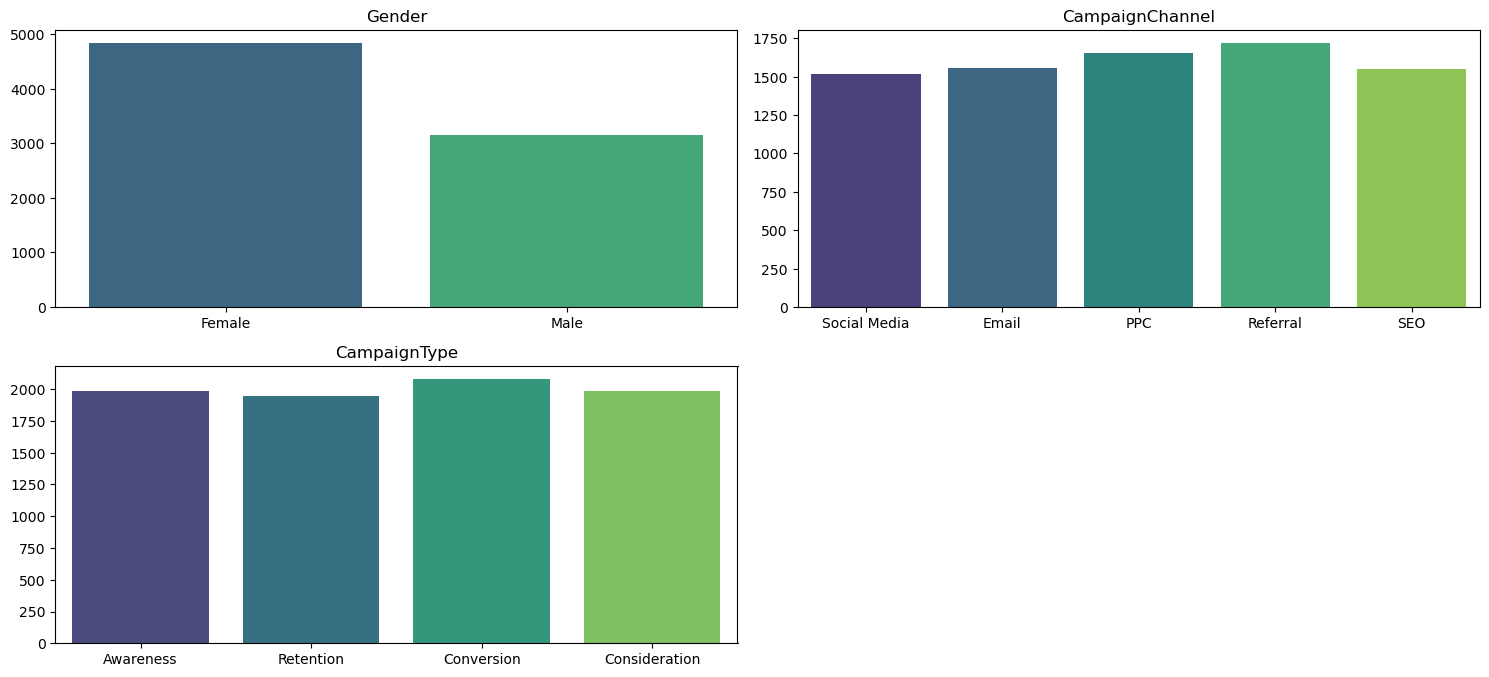

In [5]:
# Distributions of categorical features
categorical_features = df.select_dtypes(include=['object']).columns

plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 2, i+1)
    sns.countplot(data=df, x=feature, palette='viridis')
    plt.title(f'{feature}')
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

The categorical features may be broken down as follows: 
- **Gender**: The majority of customers are female, making up a significantly larger portion of the dataset compared to males. This indicates a potential need for targeted marketing strategies that consider this demographic distribution.

-  **Campaign Channel**: The usage of different marketing channels is relatively balanced. Social Media, Email, PPC (Pay-Per-Click), Referral, and SEO (Search Engine Optimization) are all well-represented, with Social Media and PPC being slightly more prominent.

- **Campaign Type**: The distribution of campaign types is also balanced, with Awareness, Retention, Conversion, and Consideration campaigns being utilized in nearly equal proportions. This reflects a comprehensive marketing strategy aimed at different stages of the customer journey, from initial awareness to retention.

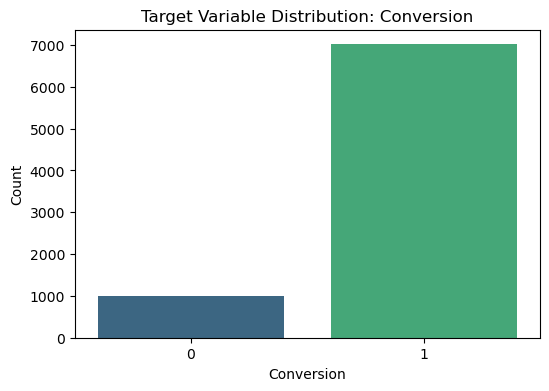

In [6]:
# Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Conversion', palette='viridis')
plt.title('Target Variable Distribution: Conversion')
plt.xlabel('Conversion')
plt.ylabel('Count')
plt.show()

In [7]:
df.Conversion.value_counts(normalize=True)

1    0.8765
0    0.1235
Name: Conversion, dtype: float64

The distribution of the target variable, Conversion, reveals that the majority of customers have successfully converted, indicating overall effective marketing campaigns. However, there is still a notable portion of customers who have not converted, suggesting room for improvement. This imbalance highlights the need to identify factors contributing to conversion and refine marketing strategies to target customers effectively.

## Preprocessing

### Feature Encoding

In [112]:
# Encoding all categorical variables
categorical_features = ['Gender', 'CampaignChannel', 'CampaignType']
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Display the first few rows of the encoded dataframe to ensure proper encoding
df_encoded.head()

Age  Income      AdSpend  ClickThroughRate  ConversionRate  WebsiteVisits  \
0   56  136912  6497.870068          0.043919        0.088031              0   
1   69   41760  3898.668606          0.155725        0.182725             42   
2   46   88456  1546.429596          0.277490        0.076423              2   
3   32   44085   539.525936          0.137611        0.088004             47   
4   60   83964  1678.043573          0.252851        0.109940              0   

   PagesPerVisit  TimeOnSite  SocialShares  EmailOpens  ...  LoyaltyPoints  \
0       2.399017    7.396803            19           6  ...            688   
1       2.917138    5.352549             5           2  ...           3459   
2       8.223619   13.794901             0          11  ...           2337   
3       4.540939   14.688363            89           2  ...           2463   
4       2.046847   13.993370             6           6  ...           4345   

   Conversion  Gender_Male  CampaignChannel_PPC  CampaignChannel_Referral  \
0           1            0                    0                         0   
1           1            1                    0                         0   
2           1            0                    1                         0   
3           1            0                    1                         0   
4           1            0                    1                         0   

   CampaignChannel_SEO  CampaignChannel_Social Media  \
0                    0                             1   
1                    0                             0   
2                    0                             0   
3                    0                             0   
4                    0                             0   

   CampaignType_Consideration  CampaignType_Conversion  CampaignType_Retention  
0                           0                        0                       0  
1                           0                        0                       1  
2                           0                        0                       0  
3                           0                        1                       0  
4                           0                        1                       0  

[5 rows x 22 columns]

### Feature Engineering

In [113]:
# Feature engineering examples
df_encoded['EmailEngagement'] = df_encoded['EmailOpens'] + df_encoded['EmailClicks']
df_encoded['SiteEngagement'] = df_encoded['WebsiteVisits'] * df_encoded['PagesPerVisit'] * df_encoded['TimeOnSite']
df_encoded['IncomePerClick'] = df_encoded['Income'] / (df_encoded['ClickThroughRate'] + 1)  # Avoiding division by zero
df_encoded['AdSpendPerClick'] = df_encoded['AdSpend'] / (df_encoded['ClickThroughRate'] + 1)  # Avoiding division by zero
df_encoded['ClickToConversionRate'] = df_encoded['ConversionRate'] / (df_encoded['ClickThroughRate'] + 1)  # Avoiding division by zero
df_encoded['TotalInteractions'] = df_encoded['WebsiteVisits'] + df_encoded['EmailOpens'] + df_encoded['EmailClicks'] + df_encoded['SocialShares']

# Display the first few rows of the dataframe with new features
df_encoded.head()

Age  Income      AdSpend  ClickThroughRate  ConversionRate  WebsiteVisits  \
0   56  136912  6497.870068          0.043919        0.088031              0   
1   69   41760  3898.668606          0.155725        0.182725             42   
2   46   88456  1546.429596          0.277490        0.076423              2   
3   32   44085   539.525936          0.137611        0.088004             47   
4   60   83964  1678.043573          0.252851        0.109940              0   

   PagesPerVisit  TimeOnSite  SocialShares  EmailOpens  ...  \
0       2.399017    7.396803            19           6  ...   
1       2.917138    5.352549             5           2  ...   
2       8.223619   13.794901             0          11  ...   
3       4.540939   14.688363            89           2  ...   
4       2.046847   13.993370             6           6  ...   

   CampaignChannel_Social Media  CampaignType_Consideration  \
0                             1                           0   
1                             0                           0   
2                             0                           0   
3                             0                           0   
4                             0                           0   

   CampaignType_Conversion  CampaignType_Retention  EmailEngagement  \
0                        0                       0               15   
1                        0                       1                9   
2                        0                       0               13   
3                        1                       0                4   
4                        1                       0               12   

   SiteEngagement  IncomePerClick  AdSpendPerClick  ClickToConversionRate  \
0        0.000000   131151.999502      6224.499328               0.084328   
1      655.793108    36133.160944      3373.352974               0.158104   
2      226.888030    69242.009306      1210.521530               0.059823   
3     3134.851039    38752.253778       474.262130               0.077359   
4        0.000000    67018.338859      1339.379886               0.087752   

   TotalInteractions  
0                 34  
1                 56  
2                 15  
3                140  
4                 18  

[5 rows x 28 columns]

The following engineered features were created to enhance the model's ability to predict customer conversions and provide deeper insights into customer behavior:

- **EmailEngagement**: 
  - Combines the number of email opens and email clicks to represent overall engagement with email marketing.
  - Formula: `EmailEngagement = EmailOpens + EmailClicks`

- **SiteEngagement**: 
  - Measures the level of engagement on the website by combining the number of website visits, pages visited per session, and the average time spent on the site.
  - Formula: `SiteEngagement = WebsiteVisits * PagesPerVisit * TimeOnSite`

- **AdSpendPerClick**: 
  - Calculates the amount of money spent per click on advertisements, providing insight into the cost-effectiveness of ad spending.
  - Formula: `AdSpendPerClick = AdSpend / (ClickThroughRate + 1)`

- **ClickToConversionRate**: 
  - Represents the efficiency of converting clicks into actual conversions.
  - Formula: `ClickToConversionRate = ConversionRate / (ClickThroughRate + 1)`

- **IncomePerClick**: 
  - Combines the income and click-through rate to provide an understanding of the potential value generated per click.
  - Formula: `IncomePerClick = Income / (ClickThroughRate + 1)`

- **TotalInteractions**: 
  - Aggregates various customer interactions such as social shares, email opens, email clicks, and previous purchases to give an overall measure of customer engagement.
  - Formula: `TotalInteractions = SocialShares + EmailOpens + EmailClicks + PreviousPurchases`

In [114]:
# Replace any infinite values with NaN and then fill NaNs with 0
df_encoded.replace([float('inf'), float('-inf')], float('nan'), inplace=True)
df_encoded.fillna(0, inplace=True)

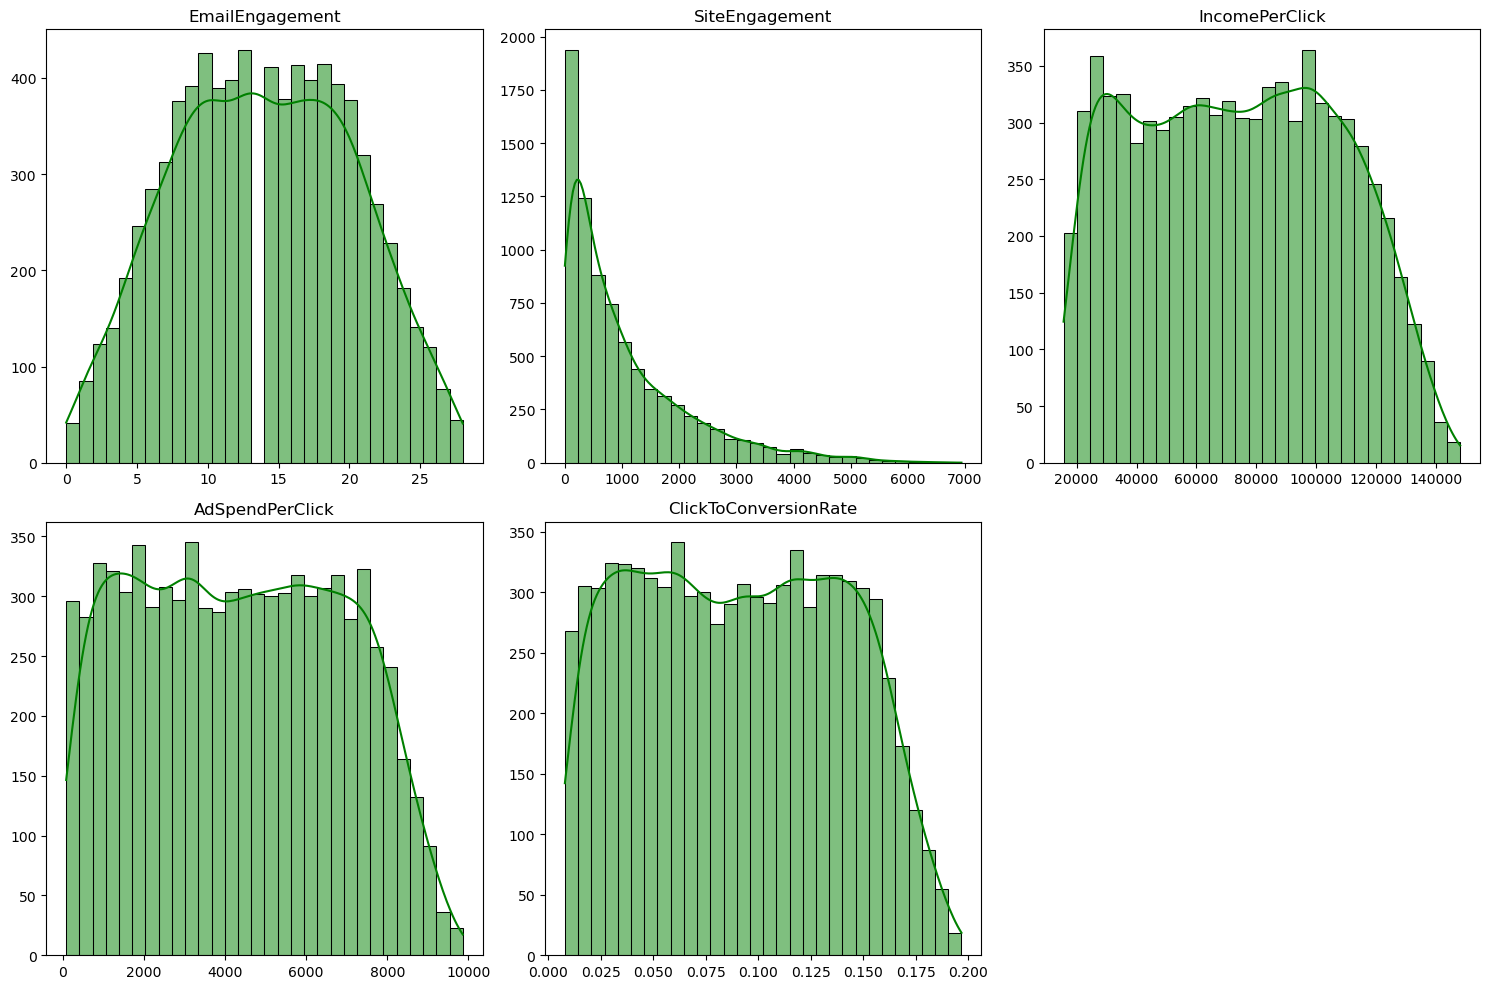

In [115]:
# Visualize the distribution of engineered numerical features using Seaborn
engineered_numerical_features = ['EmailEngagement', 'SiteEngagement', 'IncomePerClick', 
                                 'AdSpendPerClick', 'ClickToConversionRate']

num_engineered_features = len(engineered_numerical_features)
num_cols = 3
num_rows = (num_engineered_features // num_cols) + (num_engineered_features % num_cols > 0)

plt.figure(figsize=(15, num_rows * 5))
for i, feature in enumerate(engineered_numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(df_encoded[feature], bins=30, kde=True, color='green')
    plt.title(f'{feature}')
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

The distributions of the engineered features provide interesting insights into customer behavior:

- **EmailEngagement**: The distribution is fairly uniform with a slight peak around the middle values, indicating that most customers have moderate levels of email engagement, with fewer customers at the extremes.

- **SiteEngagement**: This feature shows a higher concentration at lower values, suggesting that while some users are highly engaged, the majority of users have lower levels of site engagement. As this distributions exhibits a noteble right skew, it may need to be normalized later.

- **IncomePerClick**: The distribution of IncomePerClick is uniform, reflecting varied economic value per click among customers. This suggests a diverse range of income levels affecting click behavior.

- **AdSpendPerClick**: The distribution is fairly uniform but with a higher concentration at mid to high values, indicating that many customers incur significant ad spend per click, pointing to a generally higher cost of advertising for effective clicks.

- **ClickToConversionRate**: The distribution is uniform with peaks around the mid-values, suggesting varied efficiency in converting clicks into actual conversions. This implies that some customers are more likely to convert after clicking than others, highlighting areas for optimizing conversion strategies.

### Correlation Matrix

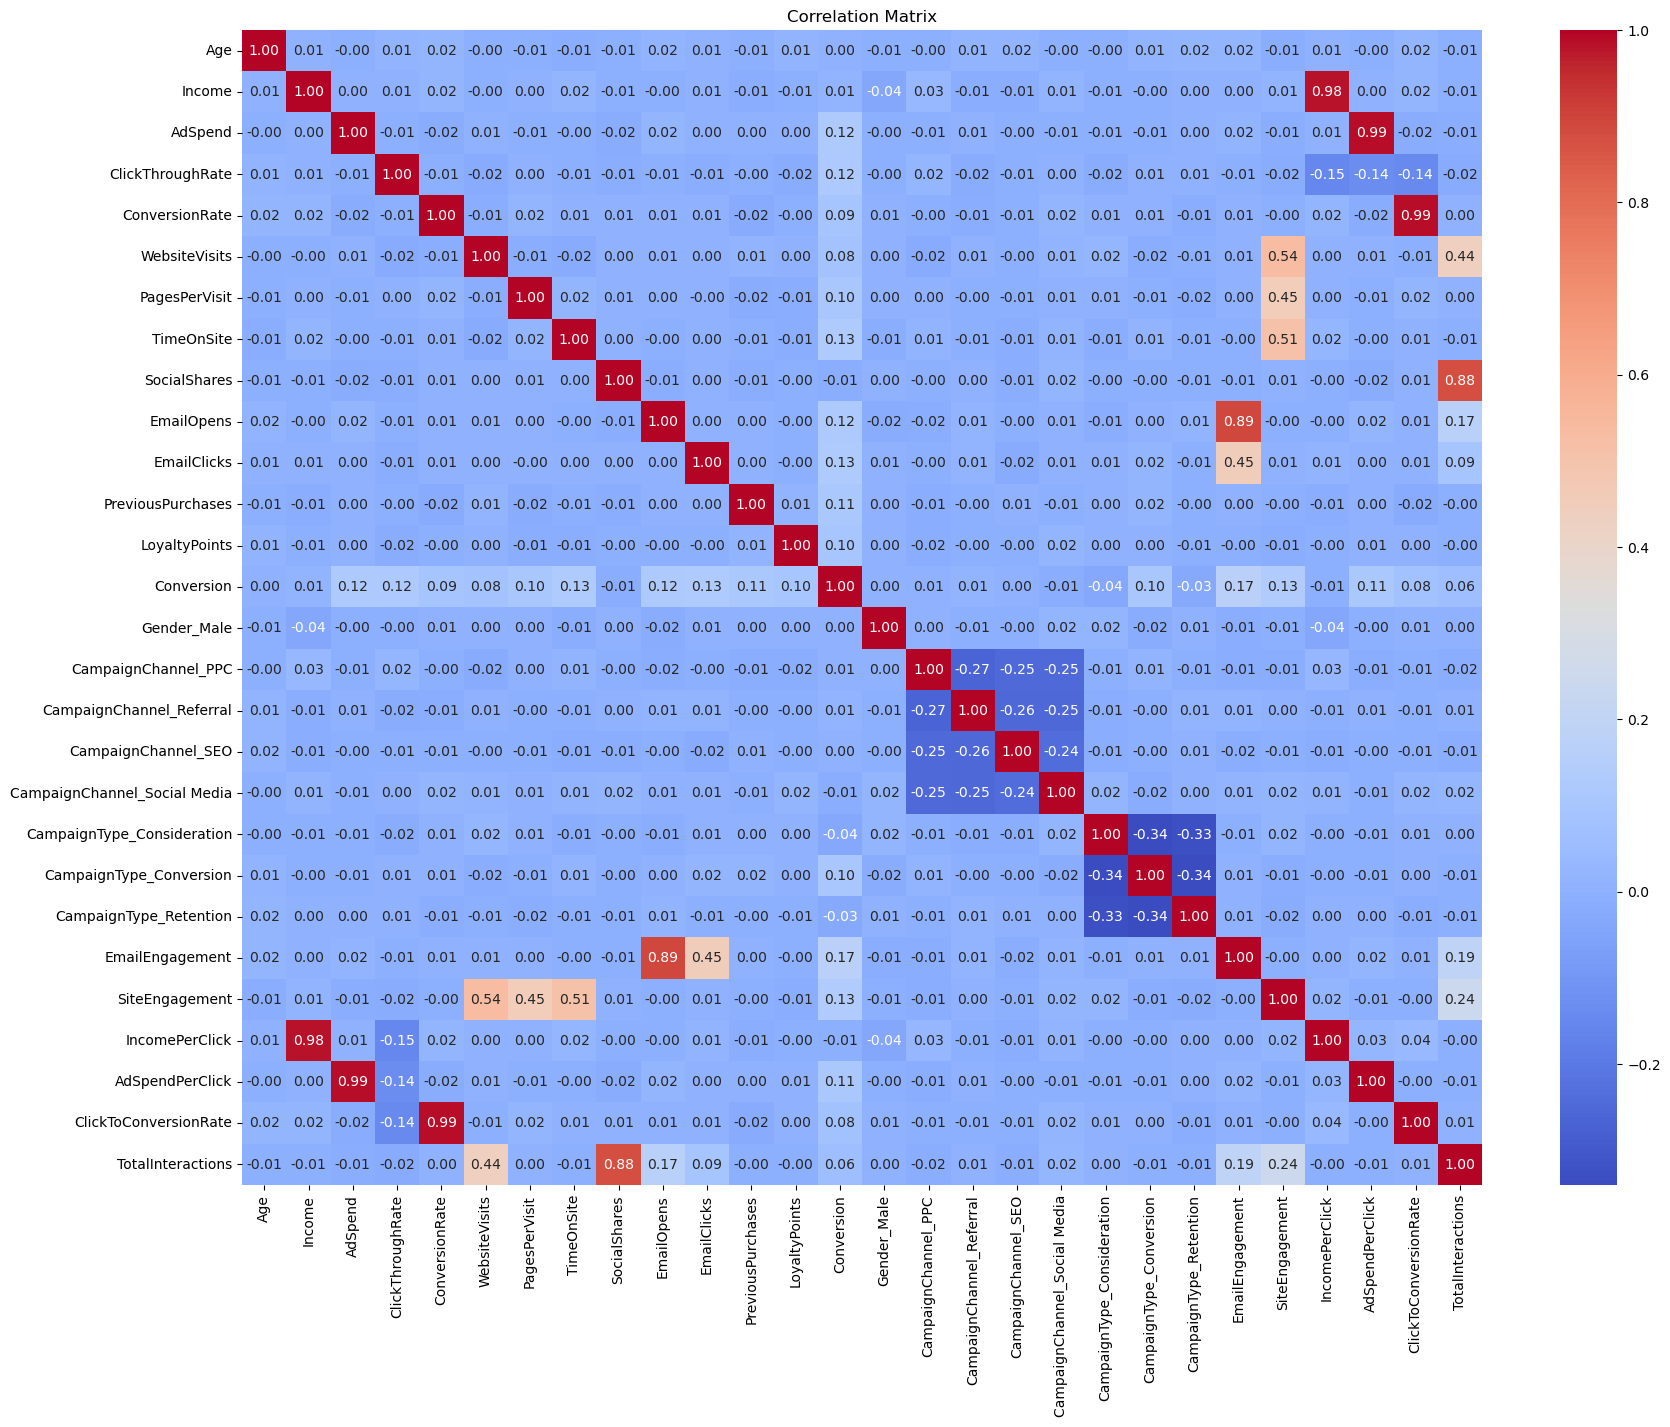

In [116]:
# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

The correlation matrix provides a comprehensive view of the relationships between different features in the dataset. Here are some key observations:

- **High Correlation Due to Derived Features**:
  - **Income and IncomePerClick**: Strong positive correlation (0.98), indicating that higher income is directly associated with higher income per click. This high correlation is expected as IncomePerClick is derived from Income.
  - **AdSpendPerClick and Income**: High positive correlation (0.99), suggesting that higher ad spend per click is closely related to higher income. This is also due to AdSpendPerClick being a derived feature.
  - **ConversionRate and ClickToConversionRate**: Perfect positive correlation (0.99), indicating that these metrics are essentially measuring the same aspect of user behavior, which is expected since ClickToConversionRate is derived from ConversionRate.

- **Moderate Correlation**:
  - **SiteEngagement and TimeOnSite**: Moderate positive correlation (0.53), suggesting that higher site engagement is associated with more time spent on the site.
  - **TotalInteractions and SocialShares**: Moderate positive correlation (0.88), indicating that total interactions increase with more social shares.

- **Low to No Correlation**:
  - Most other features have low or no significant correlation with each other, indicating a diverse set of variables that capture different aspects of customer behavior.

## Predicting Customer Conversion

### Training and Test Split

In [117]:
# Split the original data into training and test sets
X = df_encoded.drop('Conversion', axis=1)
y = df_encoded['Conversion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [118]:
# Drop less important features based on the feature importance plot
features_to_drop = ['CampaignChannel_Referral', 'CampaignType_Consideration', 'CampaignType_Retention', 
                    'TotalInteractions', 'CampaignChannel_Social Media', 'IncomePerClick', 
                    'SocialShares', 'CampaignChannel_PPC', 'Income', 'Age']

X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

In [119]:
# Apply Box-Cox transformation to SiteEngagement in the training data
X_train['SiteEngagement'], lam = boxcox(X_train['SiteEngagement'] + 1)  # Adding 1 to avoid log of zero

# Apply the same Box-Cox transformation to the test data using the lambda value from the training data
X_test['SiteEngagement'] = boxcox(X_test['SiteEngagement'] + 1, lmbda=lam)

# List of features to normalize (excluding the target column)
features_to_normalize = X_train.columns

# Min-max normalization after Box-Cox transformation
scaler = MinMaxScaler()
X_train[features_to_normalize] = scaler.fit_transform(X_train[features_to_normalize])
X_test[features_to_normalize] = scaler.transform(X_test[features_to_normalize])

### Apply SMOTE to Training Data

In [120]:
# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### Baseline XGBoost Classifier

In [121]:
# Train the XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the XGBoost model
y_pred_xgb = xgb_model.predict(X_test)
y_scores_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Print classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.70      0.46      0.56       296
           1       0.93      0.97      0.95      2104

    accuracy                           0.91      2400
   macro avg       0.81      0.72      0.75      2400
weighted avg       0.90      0.91      0.90      2400



### Hyperparameter Tuning

In [45]:
# Define parameter grid for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2], 
    'n_estimators': [100, 200, 300],     
    'max_depth': [2, 3, 4],                   
    'min_child_weight': [1, 3, 5],              
    'subsample': [0.6, 0.7, 0.8],             
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1]               
}

# Initialize GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(estimator=XGBClassifier(random_state=42),
                               param_grid=param_grid,
                               cv=3,
                               n_jobs=-1,
                               verbose=2,
                               scoring='f1')

grid_search_xgb.fit(X_train, y_train)

# Print best parameters
print(f"Best parameters found: {grid_search_xgb.best_params_}")

# Evaluate the best model
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_best_xgb))
print(classification_report(y_test, y_pred_best_xgb))

Fitting 3 folds for each of 3888 candidates, totalling 11664 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 300, 'reg_alpha': 0.1, 'subsample': 0.7}
[[ 132  164]
 [   9 2095]]
              precision    recall  f1-score   support

           0       0.94      0.45      0.60       296
           1       0.93      1.00      0.96      2104

    accuracy                           0.93      2400
   macro avg       0.93      0.72      0.78      2400
weighted avg       0.93      0.93      0.92      2400



In [122]:
# Evaluate the best XGBoost model using cross-validation
cv_scores_xgb = cross_val_score(best_xgb_model, X, y, cv=5, scoring='f1')
print(f"Cross-validation scores: {cv_scores_xgb}")
print(f"Mean cross-validation score: {cv_scores_xgb.mean()}")

Cross-validation scores: [0.97020097 0.96585029 0.967519   0.94647696 0.9286439 ]
Mean cross-validation score: 0.9557382257706291


### XGBoost Feature Importance

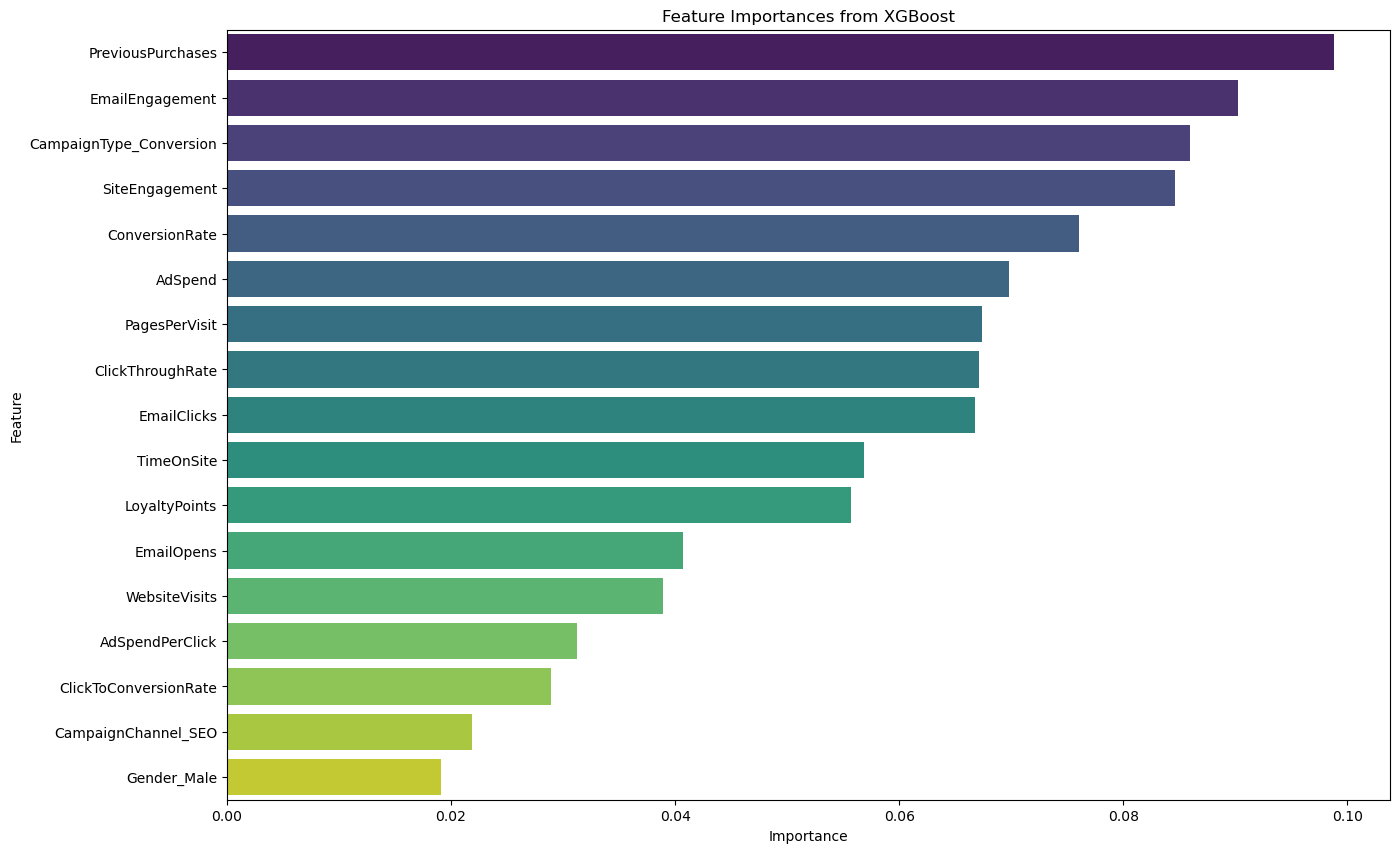

In [84]:
# Get feature importances from the best XGBoost model
importances_xgb = best_xgb_model.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
features_xgb = X_train.columns

# Create a DataFrame for plotting
feature_importance_df_xgb = pd.DataFrame({
    'Feature': features_xgb[indices_xgb],
    'Importance': importances_xgb[indices_xgb]
})

# Plot the feature importances
plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_xgb, palette='viridis')
plt.title('Feature Importances from XGBoost')
plt.show()

These features provide valuable insights into the factors that most significantly influence customer conversions, guiding marketing strategies and optimization efforts. Some of the most noteable features include:

- **PreviousPurchases**: Customers who have previously made purchases are more likely to convert again, highlighting the value of customer loyalty and repeat business.

- **EmailEngagement**: Customer interaction with email campaigns strongly correlates with conversion rates. This suggests that email marketing strategies are highly effective.

- **CampaignType_Conversion**: Campaigns specifically designed for conversion appear to be highly effective in driving customer action. This emphasizes the importance of targeted marketing efforts aimed at converting leads into customers.

- **SiteEngagement**: Higher engagement on the website (e.g., browsing, interaction with content) is a strong indicator of conversion likelihood. This underscores the need for an engaging and user-friendly website.

### Confusion Matrix

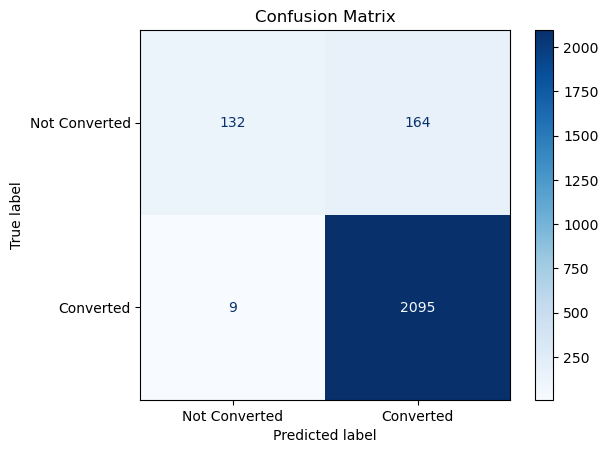

In [48]:
# Confusion Matrix using ConfusionMatrixDisplay.from_estimator
ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test, y_test, display_labels=['Not Converted', 'Converted'], cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

This confusion matrix provides some key insights into the actual performance and potential applications of the model. We can see that this model exhibits:

- **High True Positives**: The model is highly effective in identifying customers who will convert (2095), which is crucial for targeted marketing efforts.
- **Moderate False Positives**: There are some instances where the model incorrectly predicts conversions (164), which could lead to wasted marketing resources.
- **Low False Negatives**: The model has a low number of missed conversions (9), indicating it rarely fails to identify converting customers.
- **Low True Negatives**: The model has fewer correctly identified non-conversions (132), suggesting it is more focused on predicting conversions.

Overall, the model demonstrates strong performance in predicting customer conversions with high accuracy and precision, making it a valuable tool for optimizing marketing strategies.

### ROC Curve

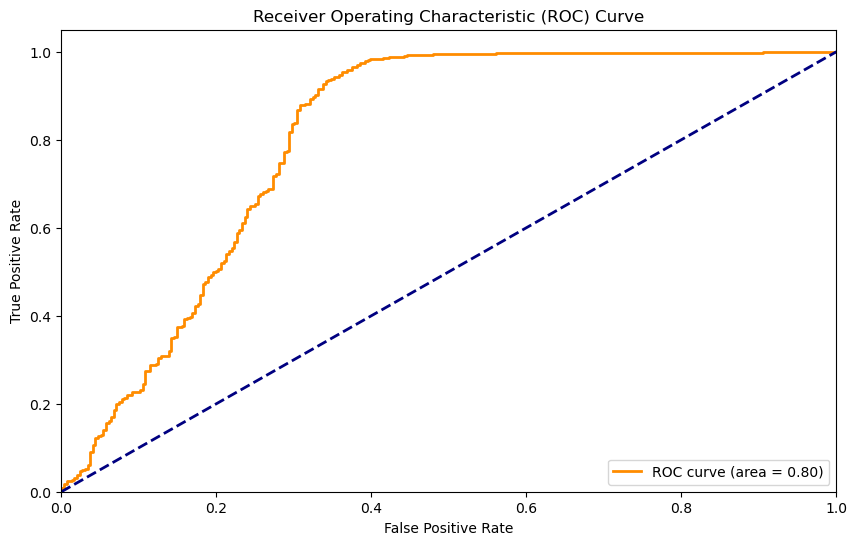

In [49]:
# ROC Curve
y_scores = best_xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The high AUC value of 0.80 indicates that the model performs well in distinguishing between converted and non-converted customers. This ROC curve shows that the model is effective at predicting conversions, providing a good balance between sensitivity and specificity.


### Precision-Recall Curve

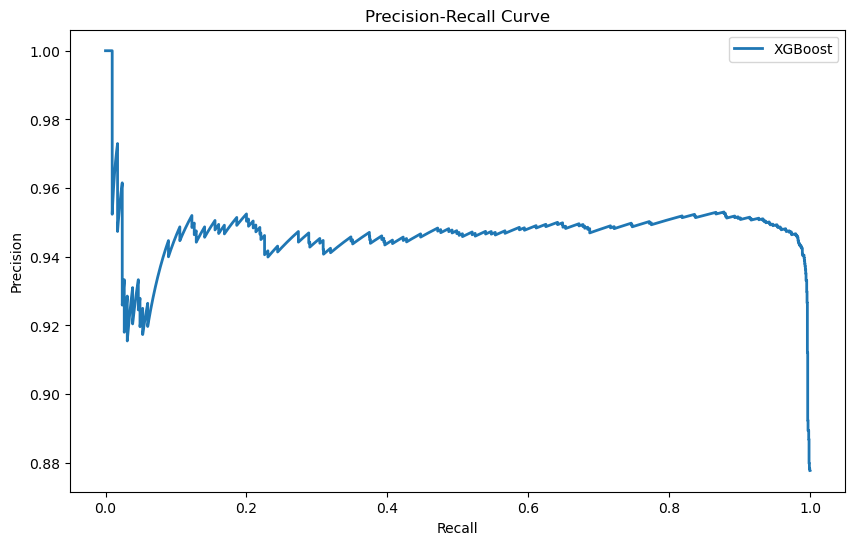

In [50]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='XGBoost', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Overall, the curve demonstrates that the model performs well in distinguishing between positive and negative classes, maintaining a balance between precision and recall for most of the range.

## Customer Segmentation

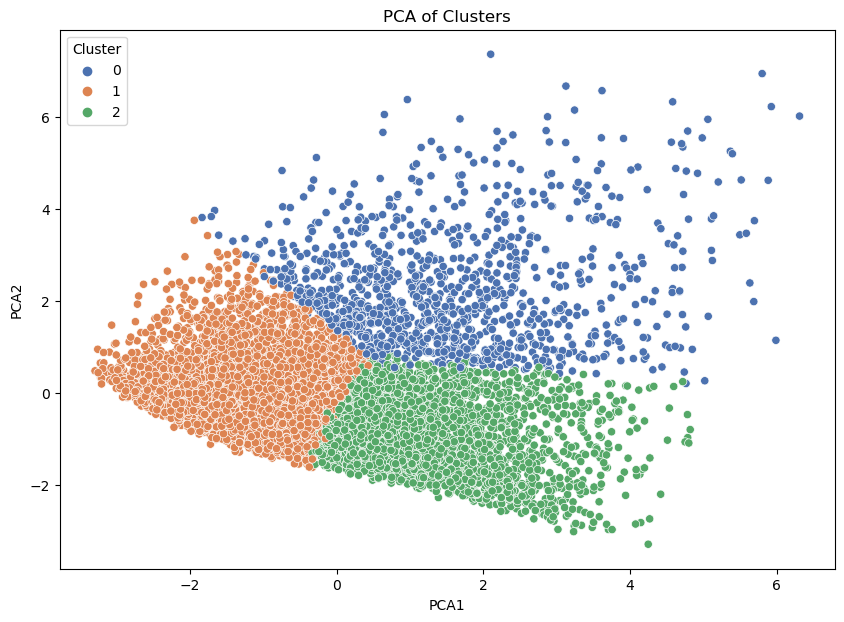

In [91]:
# Select features for clustering including the new interaction features
features = ['EmailEngagement', 'SiteEngagement', 'ConversionRate', 'Gender_Male', 'Age', 'Income',
            'Income_EmailEngagement', 'Income_SiteEngagement', 'Income_ConversionRate']

# Standardize the features
scaler = StandardScaler()
df_encoded_scaled = scaler.fit_transform(df_encoded[features])

# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_encoded['Cluster'] = kmeans.fit_predict(df_encoded_scaled)

# Cell 1: Apply PCA for visualization and plot the PCA components
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
df_encoded_pca = pca.fit_transform(df_encoded_scaled)

# Add the PCA components to the DataFrame
df_encoded['PCA1'] = df_encoded_pca[:, 0]
df_encoded['PCA2'] = df_encoded_pca[:, 1]

# Plot the PCA components 
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_encoded, x='PCA1', y='PCA2', hue='Cluster', palette='deep')
plt.title('PCA of Clusters')
plt.show()

The PCA plot effectively illustrates the separation and characteristics of the three customer clusters. The distinct clusters indicate that the clustering algorithm and the selected features are successful in segmenting the customers into meaningful groups. This segmentation can be used to tailor marketing strategies, improve customer engagement, and optimize resource allocation based on the specific characteristics of each cluster.

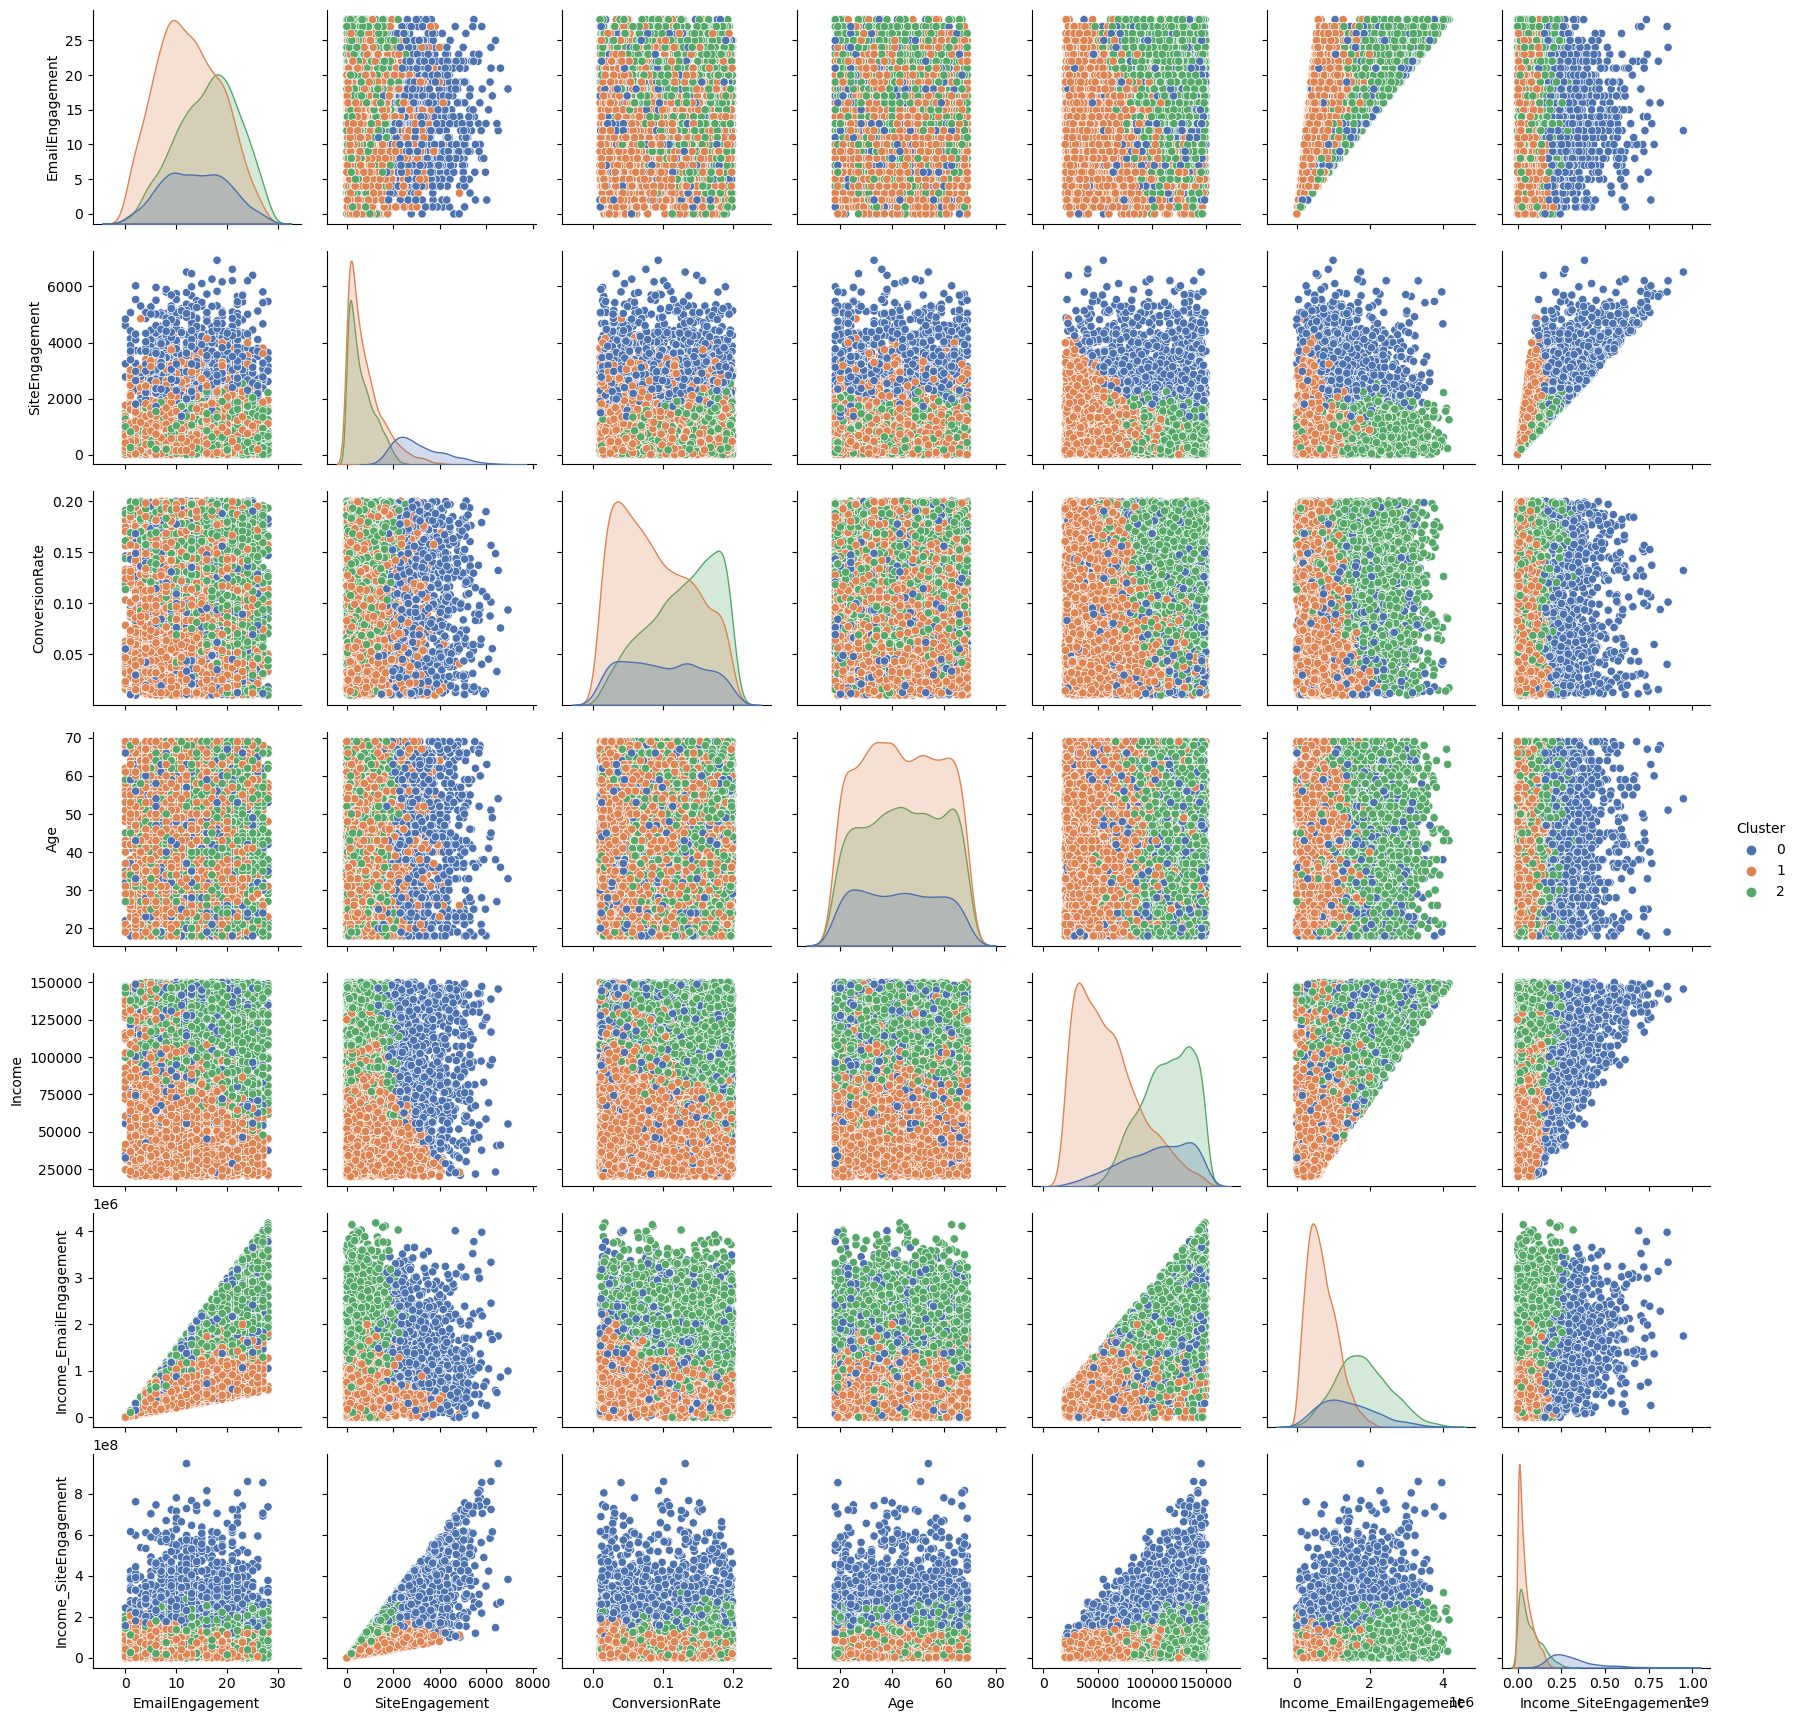

In [80]:
# Exclude less informative features
features = ['EmailEngagement', 'SiteEngagement', 'ConversionRate', 'Age', 'Income',
            'Income_EmailEngagement', 'Income_SiteEngagement']

# Plot the pair plot with the selected features and clusters
sns.pairplot(df_encoded, hue='Cluster', vars=features, palette='deep')
plt.show()

#### Key Observations:

1. **EmailEngagement vs. Other Features**:
   - **EmailEngagement vs. Income**: There is a positive correlation between EmailEngagement and Income across all clusters, with Cluster 0 (blue) showing higher engagement for lower income, and Cluster 1 (orange) having a more uniform distribution.
   - **EmailEngagement vs. ConversionRate**: A positive trend is observed, especially in Cluster 2 (green), indicating that higher email engagement is associated with higher conversion rates.

2. **SiteEngagement vs. Other Features**:
   - **SiteEngagement vs. Age**: Site engagement does not show a strong correlation with age across clusters, suggesting that engagement levels are relatively consistent across different age groups.
   - **SiteEngagement vs. Income**: Similar to EmailEngagement, SiteEngagement has a positive correlation with Income, with distinct patterns in each cluster.

3. **ConversionRate vs. Other Features**:
   - **ConversionRate vs. Income**: ConversionRate increases with Income, particularly in Cluster 2, indicating that higher-income customers tend to have higher conversion rates.
   - **ConversionRate vs. Age**: Conversion rates appear to be relatively uniform across different age groups within each cluster.

4. **Age vs. Other Features**:
   - **Age vs. Income**: There is a slight positive correlation between Age and Income, with Cluster 1 (orange) having younger customers with lower income and Cluster 0 (blue) showing older customers with higher income.

5. **Interaction Features**:
   - **Income_EmailEngagement** and **Income_SiteEngagement**: These interaction features show stronger correlations within clusters, highlighting the combined effect of income and engagement levels on clustering.

**What do these clusters represent?**
   - **Cluster 0 (Blue)**: Represents a segment with varied email and site engagement, and higher income levels.
   - **Cluster 1 (Orange)**: Characterized by lower income and engagement levels, with younger customers predominantly.
   - **Cluster 2 (Green)**: Shows high engagement levels and varied income, suggesting a segment of highly engaged customers with diverse income levels.

In [81]:
# Calculate evaluation metrics
sil_score = silhouette_score(df_encoded_scaled, df_encoded['Cluster'])
db_score = davies_bouldin_score(df_encoded_scaled, df_encoded['Cluster'])
ch_score = calinski_harabasz_score(df_encoded_scaled, df_encoded['Cluster'])

print(f'Silhouette Score: {sil_score}')
print(f'Davies-Bouldin Score: {db_score}')
print(f'Calinski-Harabasz Score: {ch_score}')

Silhouette Score: 0.1906245200377695
Davies-Bouldin Score: 1.728680766116476
Calinski-Harabasz Score: 1725.8474542082997


Overall, while the clustering has produced some distinct groups, the moderate Silhouette and Davies-Bouldin Scores suggest that there might be some overlap between clusters, and there could be potential for improving the clustering algorithm or feature selection to achieve better-defined clusters.

## Evaluating Campaign Effectiveness

In [100]:
# Group by CampaignChannel and CampaignType to analyze conversion rates
channel_effectiveness = df.groupby('CampaignChannel')['Conversion'].mean()
type_effectiveness = df.groupby('CampaignType')['Conversion'].mean()

# Print the results
print("Channel Effectiveness:\n", channel_effectiveness)
print("\nType Effectiveness:\n", type_effectiveness)

Channel Effectiveness:
 CampaignChannel
Email           0.870263
PPC             0.882779
Referral        0.883072
SEO             0.876774
Social Media    0.868334
Name: Conversion, dtype: float64

Type Effectiveness:
 CampaignType
Awareness        0.855634
Consideration    0.855634
Conversion       0.933558
Retention        0.858243
Name: Conversion, dtype: float64


## Conclusion

This project was aimed to enhance our understanding of customer behavior and marketing strategies using a dataset encompassing customer engagement metrics, demographic information, and campaign interactions. Here are the key findings and potential areas for future exploration:

### Conversion Prediction

We developed a robust model to predict customer conversions using XGBoost, which demonstrated strong performance in distinguishing between converted and non-converted customers. The optimized model provided valuable insights into the key factors driving customer conversions, highlighting the importance of features such as EmailEngagement, SiteEngagement, and PreviousPurchases.

### Cluster Analysis

Our cluster analysis using K-Means clustering revealed distinct customer segments based on their engagement and demographic profiles. These segments allow us to tailor strategies to specific customer groups. Despite achieving reasonable cluster separation, there is room for improvement, particularly in enhancing cluster interpretability and exploring alternative clustering algorithms.

### Campaign Effectiveness

We evaluated the effectiveness of different campaign channels and types, identifying high conversion rates across various channels such as Email, PPC, and Social Media.

### Future Potential Areas for Improvement

- **Feature Engineering:** Further feature engineering, such as creating additional interaction features or incorporating external data sources, could improve model performance and clustering results.
- **Advanced Clustering Techniques:** Exploring advanced clustering techniques like DBSCAN or Gaussian Mixture Models may provide better cluster separation and interpretability.
- **A/B Testing:** Implementing A/B testing strategies can optimize marketing efforts, such as testing different email subject lines, ad copies, landing page designs, and loyalty program incentives.

### A/B Testing Opportunities

Given the insights gained from this project, several A/B testing opportunities can be explored to further optimize marketing strategies:
- **Email Campaigns:** Test different subject lines, content personalization, and send times to improve engagement and conversion rates.
- **Ad Campaigns:** Compare ad copy variations, targeting strategies, and ad formats to determine the most effective approaches.
- **Website Engagement:** Experiment with landing page designs, CTA variations, and content personalization to enhance site engagement and conversions.
- **Loyalty Programs:** Evaluate different incentive types and communication strategies to boost loyalty program participation.
- **Conversion Rate Optimization:** Test different checkout processes and payment options to increase conversion rates.
- **Content Marketing:** Compare the performance of various content topics and formats to drive more traffic and engagement.
- **Referral Programs:** Experiment with different referral incentives and communication methods to encourage customer referrals.
